# Téléchargement et exploration des données

Télécharger les données : https://www.kaggle.com/c/detecting-insults-in-social-commentary , il s'agit d'une compétition dont le but est de détecter les propos insultants parmi des commentaires écrits sur des réseaux sociaux 

 Lire les données, extraire les commentaires et les labels de l'ensemble d'entraînement et de test

In [1]:
import pandas as pd
import numpy as np

datapath = 'insults/'
train_data = pd.read_csv(datapath+'train.csv')
test_data = pd.read_csv(datapath+"test_with_solutions.csv")

In [2]:
comments_train,comments_test,Y_train,Y_test=train_data.Comment,test_data.Comment,train_data.Insult,test_data.Insult


A l'aide de matplotlib, visualiser la répartition des commentaires

(array([2898.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1049.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

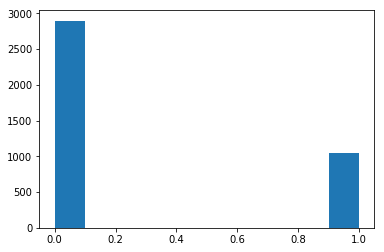

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(Y_train)

Afficher un commentaire insultant

In [4]:
import random
index=random.choice(np.where(Y_train==1)[0])
print(comments_train[index])


"Spelling mistakes? like i said, Ignorant Asshole.\xa0 So go put your butt plug in and shut your mouth..... HAHAHA estkill16, i see your getting roasted on here already,  i see your bios, a lil homo from Detroit whose moms a whore haha i wonder whose got the bigger mouth...."


# Premier essai : CountVectorizer

Transformer les commentaires avec CountVectorizer.TfIdfVectorizer (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html , https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) puis entraîner une régression logistique avec différents constantes, le tester sur l'ensemble de test (oui ...)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=10,max_df=0.9)
cv.fit(comments_train)
X_train=cv.transform(comments_train)
X_test=cv.transform(comments_test)
X_train.shape

(3947, 1071)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
param_grid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100] }
logreg = GridSearchCV(LogisticRegression(penalty='l2'), param_grid,
                      scoring='precision', n_jobs=-1, cv=5)
logreg.fit(X_train, Y_train)
logreg.grid_scores_

[mean: 0.87419, std: 0.11227, params: {'C': 0.01},
 mean: 0.83261, std: 0.09348, params: {'C': 0.03},
 mean: 0.81814, std: 0.04722, params: {'C': 0.1},
 mean: 0.77612, std: 0.02828, params: {'C': 0.3},
 mean: 0.72317, std: 0.02463, params: {'C': 1},
 mean: 0.67338, std: 0.01739, params: {'C': 3},
 mean: 0.62489, std: 0.00511, params: {'C': 10},
 mean: 0.57887, std: 0.01580, params: {'C': 30},
 mean: 0.54306, std: 0.01093, params: {'C': 100}]

In [12]:
clf=logreg.best_estimator_
clf.score(X_test,Y_test)

0.7476388364185871

En regardant les coefficients les plus importants de votre régression logistique, regarder les 10 mots (ou n-grams) les plus associés aux commentaires insultants

In [13]:
clf=logreg.best_estimator_
coeffs=clf.coef_[0]
indexes=np.argsort(coeffs)
top_10=[cv.get_feature_names()[indexes[i]] for i in range(-10,0)]
top_10

['shut',
 'ignorant',
 'fuck',
 'loser',
 'ass',
 'moron',
 'bitch',
 'stupid',
 'dumb',
 'idiot']

# Second essai : Word2Vec

importer (éventuellement installer) gensim et entraîner un modèle Word2Vec sur l'ensemble des commentaires

In [14]:
from gensim.models import Word2Vec


définir une fonction prenant en argument une chaine de caractère et qui rempalce les caractères suivants : '"\n#0123456789*$/(): par un espace

In [15]:
forbid_car= '\'\"\n#0123456789*$/:()\\'
def clean(sent):
    res=sent
    for car in forbid_car:
        res=res.replace(car,' ')
    return res

spliter chaque phrase en liste de mots de façon à obtenir une liste de liste et en profiter pour enlever les majuscules et nettoyer chaque phrase via la fonction précédemment définie

In [16]:
clean_comments_train=[clean(elem).lower().split(' ') for elem in comments_train]
clean_comments_test=[clean(elem).lower().split(' ') for elem in comments_test]


instancier un modèle Word2vec à partir des données nettoyées et bien structurées 

In [17]:
model=Word2Vec(clean_comments_train+clean_comments_test)

en utilisant la fonction model.wv.most_similar_cosmul regarder les mots les plus proches d'un mot de votre choix

In [23]:
model.wv.most_similar_cosmul(['trump'],)

[('smart', 0.9979934692382812),
 ('gays', 0.997841477394104),
 ('longer', 0.997499942779541),
 ('usual.', 0.9972481727600098),
 ('crazy', 0.9972244501113892),
 ('hell', 0.9972082376480103),
 ('unemployed', 0.9970417618751526),
 ('risk', 0.9969756603240967),
 ('us.', 0.996964693069458),
 ('real', 0.9969145655632019)]

en utilisant le dictionaire model.wv, convertir les commentaires textes en suite de vecteurs

un commentaire est maintenant représenté comme un liste de vecteurs, chaque liste ayant une longueur variable, utiliser la fonction de keras pad_sequences pour que tous nos commentaires soient représentés sous le bon format 

place au deep learning ! définir un modèle séquentiel keras avec une couche LSTM, une ou plusieurs couche(s) dense(s) et une couche finale d'activation logistique, le compiler et bien sûr l'entraîner, bonus pour utiliser la fonctionalité chekcpont afin de sauvegarder la meilleure version